## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=2000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=40,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.GAS, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='3Gens-Cost-2k'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.05)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=300.0, beta=5, gamma=0.001), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=500.0, beta=8, gamma=0.00194), minPower=0.5, maxPower=5.0, noiseLevel=0.05), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=700.0, beta=10, gamma=0.00482), minPower=0.5, maxPower=5.0, noiseLevel=0.05)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=2000, maxSteps=100, bufferSize=500, traceLength=15, batchSize=40, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='3Gens-Cost-2k')

Train Agents

In [18]:
def rewardFn(totalCost, outputDifferential):
    scaledCost = totalCost/(100000.0) # Scale down cost to levels near the ones found in output differential (e.g. 0.1 */ 0.01)
    costComponent = 2**(-1*(scaledCost**2)*200)
    outputComponent = 2**(-1*(outputDifferential**2)*500)
    earnedReward = costComponent*outputComponent
    
    print(f'Scaled_Cost:{scaledCost} - OutputDiff:{outputDifferential} - costComponent:{costComponent} - outputComponent:{outputComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total':earnedReward}

In [19]:
from learning.cost import ModelAdapterCost as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0916 20:34:35.292740 140456290748160 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0916 20:34:35.293556 140456290748160 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0916 20:34:35.313858 140456290748160 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: 3Gens-Cost-2k - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/3Gens-Cost-2k/model
CPU times: user 6h 5min 51s, sys: 56min 36s, total: 7h 2min 27s
Wall time: 2h 14min 50s


In [20]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled_Cost:0.038569941237190736 - OutputDiff:-0.03313584422778101 - costComponent:0.8136453098544348 - outputComponent:0.6834974751687507 - reward:0.5561245149684021
Scaled_Cost:0.03833183028880936 - OutputDiff:-0.06627055527051258 - costComponent:0.8157133436350772 - outputComponent:0.21825804716736677 - reward:0.17803600143015513
Scaled_Cost:0.03954020721133044 - OutputDiff:-0.04223944309205094 - costComponent:0.8051415808912624 - outputComponent:0.5388347215608018 - reward:0.4338382395565672
Scaled_Cost:0.039685500534411916 - OutputDiff:-0.06103541192459442 - costComponent:0.8038577937286098 - outputComponent:0.2749686878247816 - reward:0.2210357227392798
Scaled_Cost:0.03948556020225571 - OutputDiff:-0.09417076979626489 - costComponent:0.8056237427346556 - outputComponent:0.04626076898221567 - reward:0.03726877384923585
Scaled_Cost:0.03961717864477687 - OutputDiff:-0.10674706140255065 - costComponent:0.8044618056694757 - outputComponent:0.01927042821644587 - reward:0.01550232347902

Scaled_Cost:0.04383227228906551 - OutputDiff:0.0032538535702096825 - costComponent:0.7661752783591588 - outputComponent:0.9963373541697014 - reward:0.7633690496705987
Scaled_Cost:0.04383226630359719 - OutputDiff:0.0032536876660008286 - costComponent:0.7661753340912957 - outputComponent:0.9963377269700349 - reward:0.7633693908290285
Scaled_Cost:0.043832260888173845 - OutputDiff:0.003253537562197302 - costComponent:0.7661753845156034 - outputComponent:0.9963380642493057 - reward:0.7633696994837438
Scaled_Cost:0.043832256470328776 - OutputDiff:0.003253415109098391 - costComponent:0.7661754256512181 - outputComponent:0.9963383393867354 - reward:0.7633699512722598
Scaled_Cost:0.043832252194994835 - OutputDiff:0.0032532966060961027 - costComponent:0.7661754654598756 - outputComponent:0.9963386056389844 - reward:0.7633701949310923
Scaled_Cost:0.043832249059750056 - OutputDiff:0.003253209703895053 - costComponent:0.7661754946528889 - outputComponent:0.9963388008845135 - reward:0.76337037360955

Scaled_Cost:0.04383223024828214 - OutputDiff:0.0032526882906719766 - costComponent:0.7661756698109413 - outputComponent:0.9963399722490048 - reward:0.763371445597296
Scaled_Cost:0.04383223039079324 - OutputDiff:0.003252692240771837 - costComponent:0.7661756684839868 - outputComponent:0.9963399633757327 - reward:0.7633714374767129
Scaled_Cost:0.04383223053330434 - OutputDiff:0.003252696190871697 - costComponent:0.7661756671570321 - outputComponent:0.9963399545024499 - reward:0.7633714293561216
Scaled_Cost:0.04383223053330434 - OutputDiff:0.003252696190871697 - costComponent:0.7661756671570321 - outputComponent:0.9963399545024499 - reward:0.7633714293561216
Scaled_Cost:0.043832230675815445 - OutputDiff:0.0032527001409715576 - costComponent:0.7661756658300775 - outputComponent:0.9963399456291565 - reward:0.7633714212355222
Scaled_Cost:0.04383223039079324 - OutputDiff:0.003252692240771837 - costComponent:0.7661756684839868 - outputComponent:0.9963399633757327 - reward:0.7633714374767129
Sc

Scaled_Cost:0.043832230105770906 - OutputDiff:0.0032526843405685842 - costComponent:0.7661756711378972 - outputComponent:0.9963399811222742 - reward:0.7633714537178783
Scaled_Cost:0.04383223024828201 - OutputDiff:0.0032526882906684447 - costComponent:0.7661756698109425 - outputComponent:0.9963399722490127 - reward:0.7633714455973032
Scaled_Cost:0.04383223039079311 - OutputDiff:0.003252692240768305 - costComponent:0.7661756684839879 - outputComponent:0.9963399633757407 - reward:0.7633714374767201
Scaled_Cost:0.043832230533304206 - OutputDiff:0.0032526961908681657 - costComponent:0.7661756671570333 - outputComponent:0.9963399545024579 - reward:0.7633714293561289
Scaled_Cost:0.043832230675815306 - OutputDiff:0.003252700140968026 - costComponent:0.7661756658300787 - outputComponent:0.9963399456291644 - reward:0.7633714212355294
Scaled_Cost:0.04383223039079311 - OutputDiff:0.003252692240768305 - costComponent:0.7661756684839879 - outputComponent:0.9963399633757407 - reward:0.763371437476720

Scaled_Cost:0.043832230390793085 - OutputDiff:0.0032526922407674222 - costComponent:0.7661756684839881 - outputComponent:0.9963399633757427 - reward:0.7633714374767219
Scaled_Cost:0.04383223053330417 - OutputDiff:0.0032526961908672827 - costComponent:0.7661756671570337 - outputComponent:0.9963399545024599 - reward:0.7633714293561308
Scaled_Cost:0.04383223067581528 - OutputDiff:0.003252700140967143 - costComponent:0.766175665830079 - outputComponent:0.9963399456291664 - reward:0.7633714212355313
Scaled_Cost:0.043832230390793085 - OutputDiff:0.0032526922407674222 - costComponent:0.7661756684839881 - outputComponent:0.9963399633757427 - reward:0.7633714374767219
Scaled_Cost:0.04383223053330417 - OutputDiff:0.0032526961908672827 - costComponent:0.7661756671570337 - outputComponent:0.9963399545024599 - reward:0.7633714293561308
Scaled_Cost:0.04383223053330417 - OutputDiff:0.0032526961908672827 - costComponent:0.7661756671570337 - outputComponent:0.9963399545024599 - reward:0.763371429356130

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

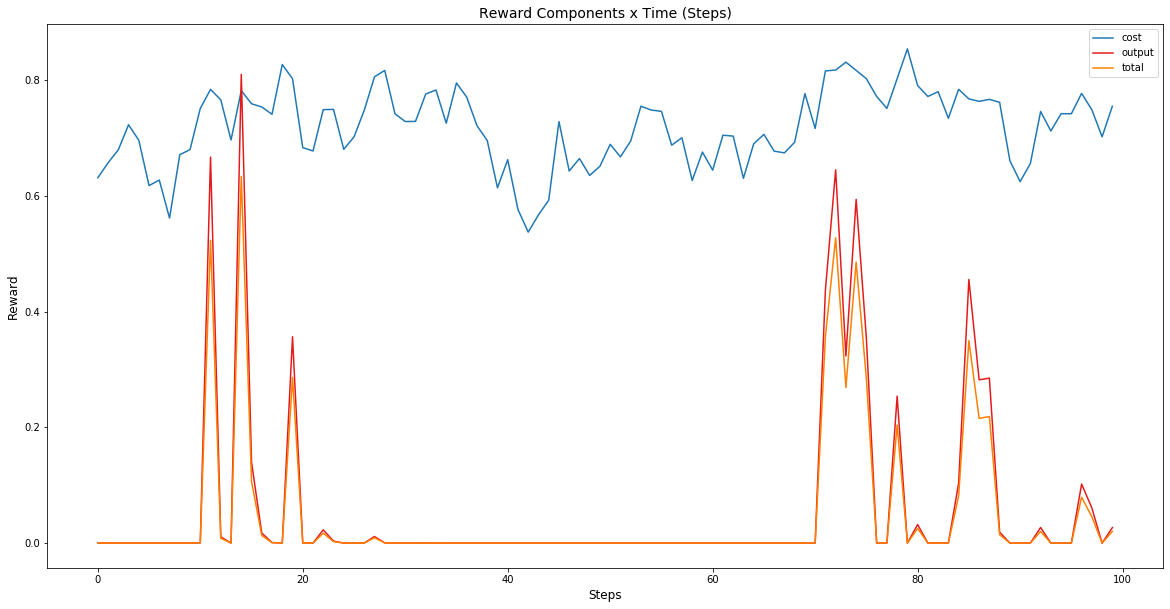

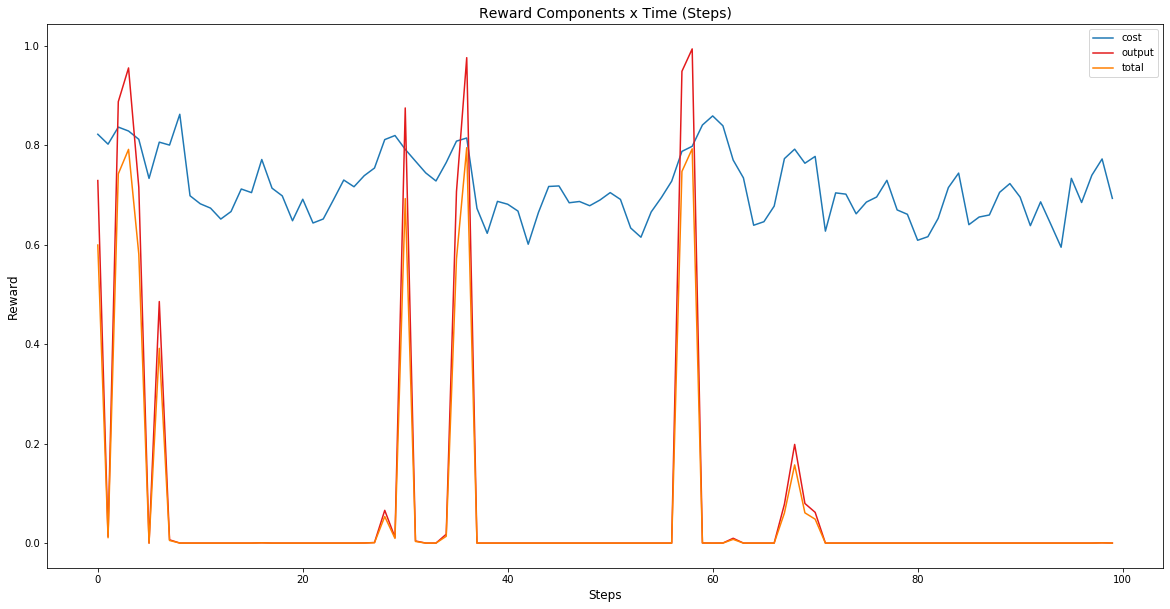

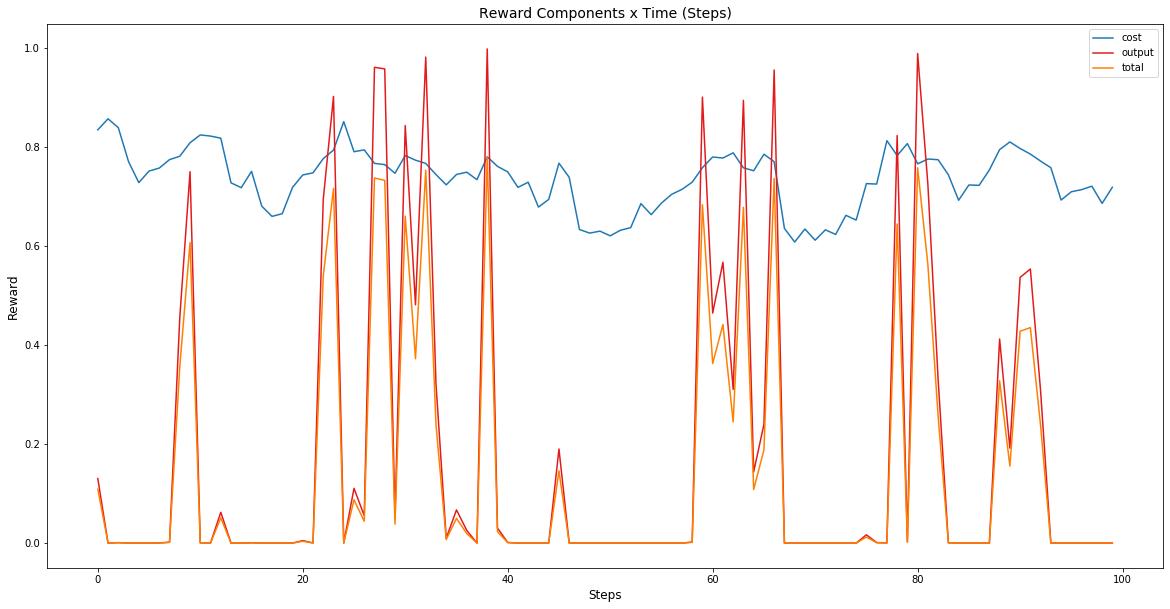

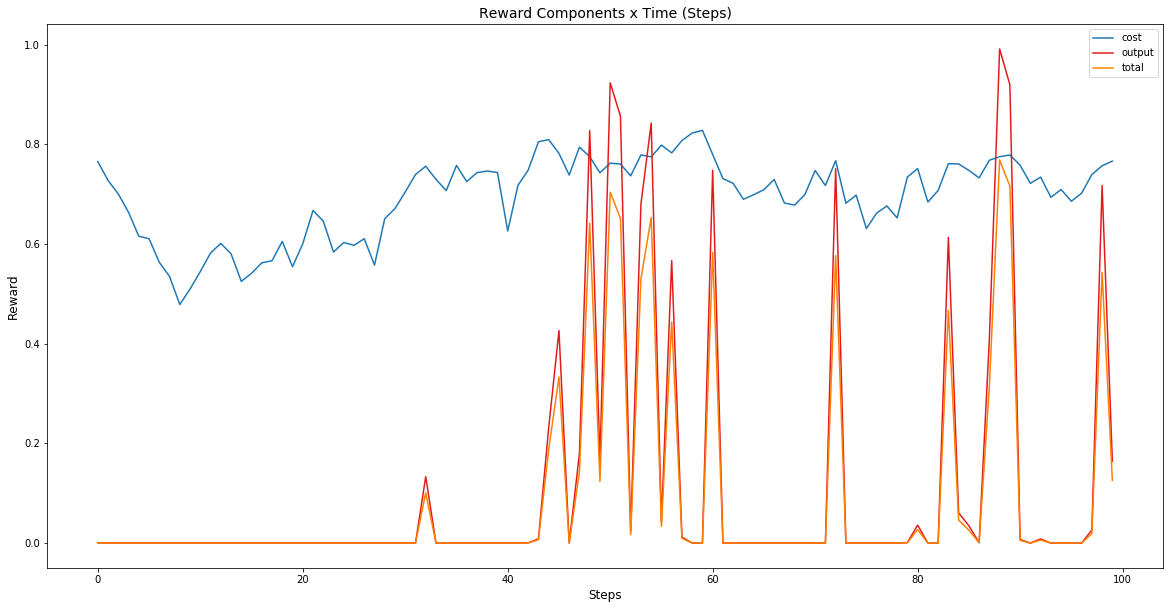

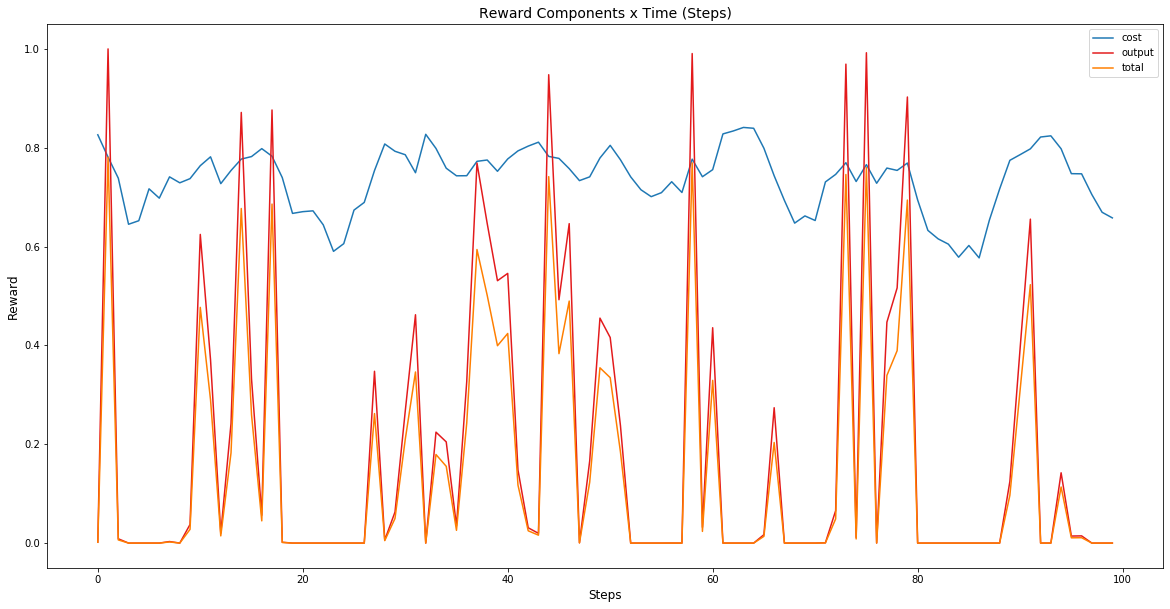

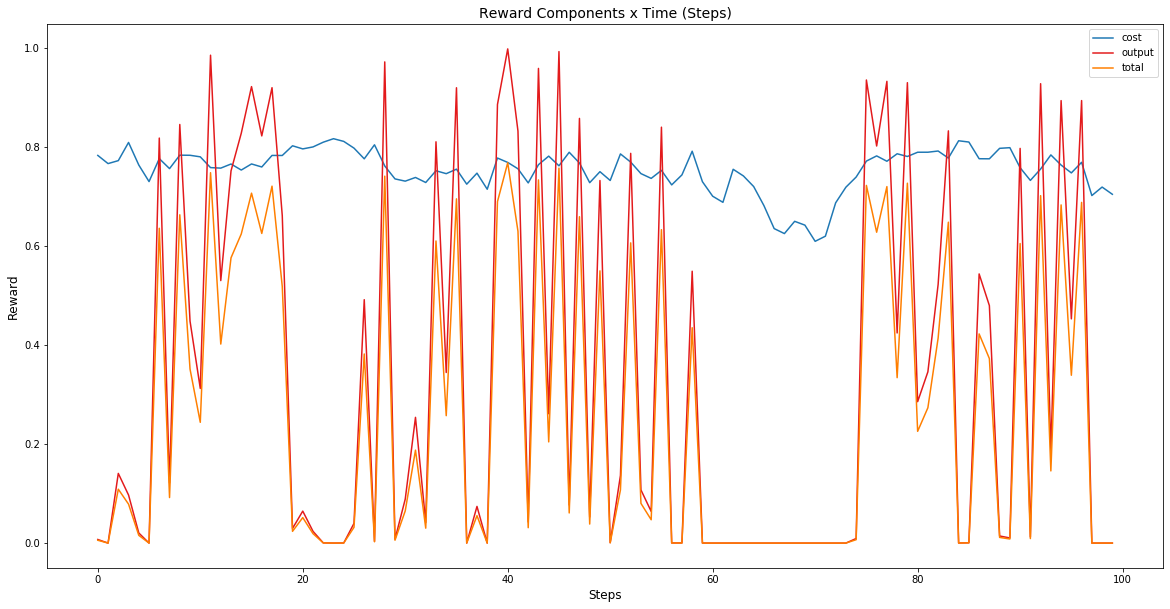

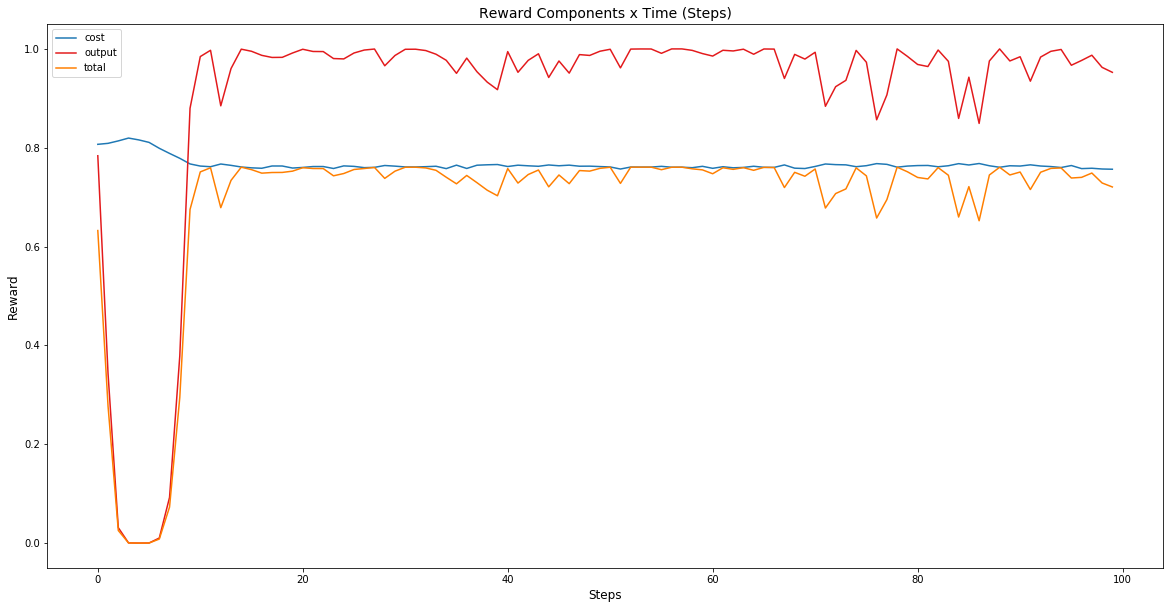

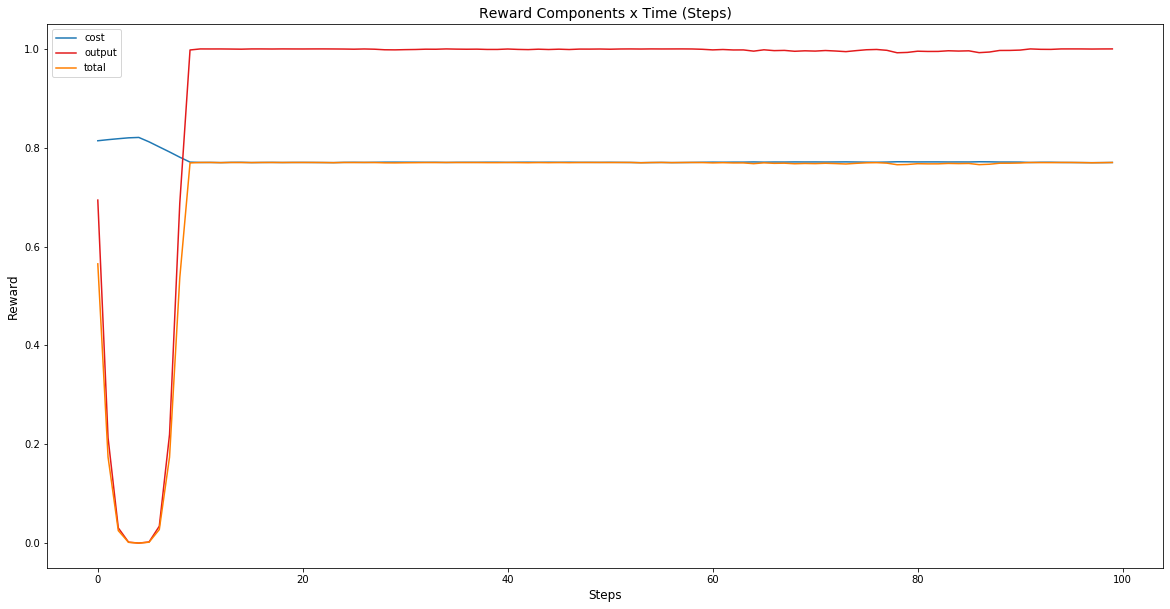

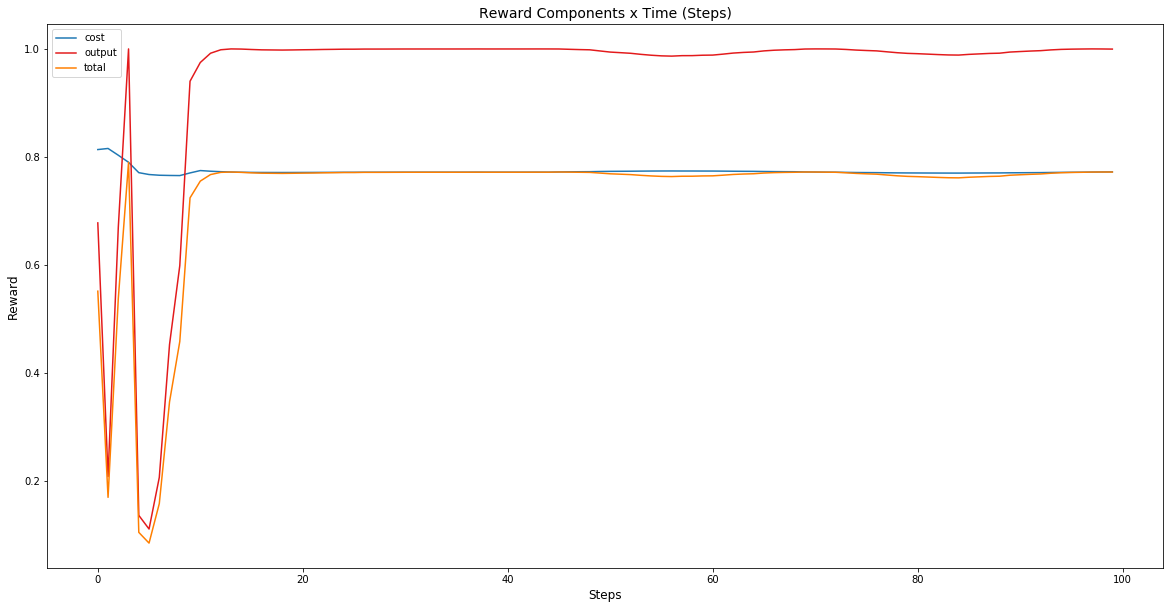

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

225.35301464961265

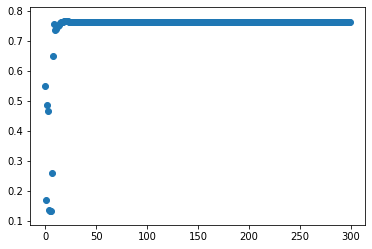

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

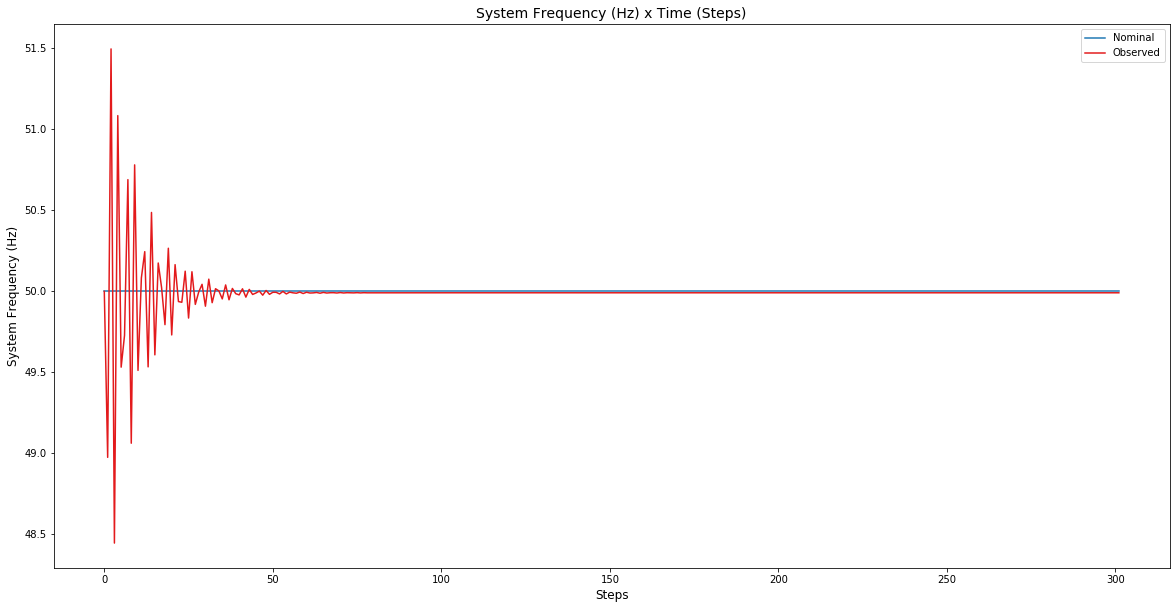

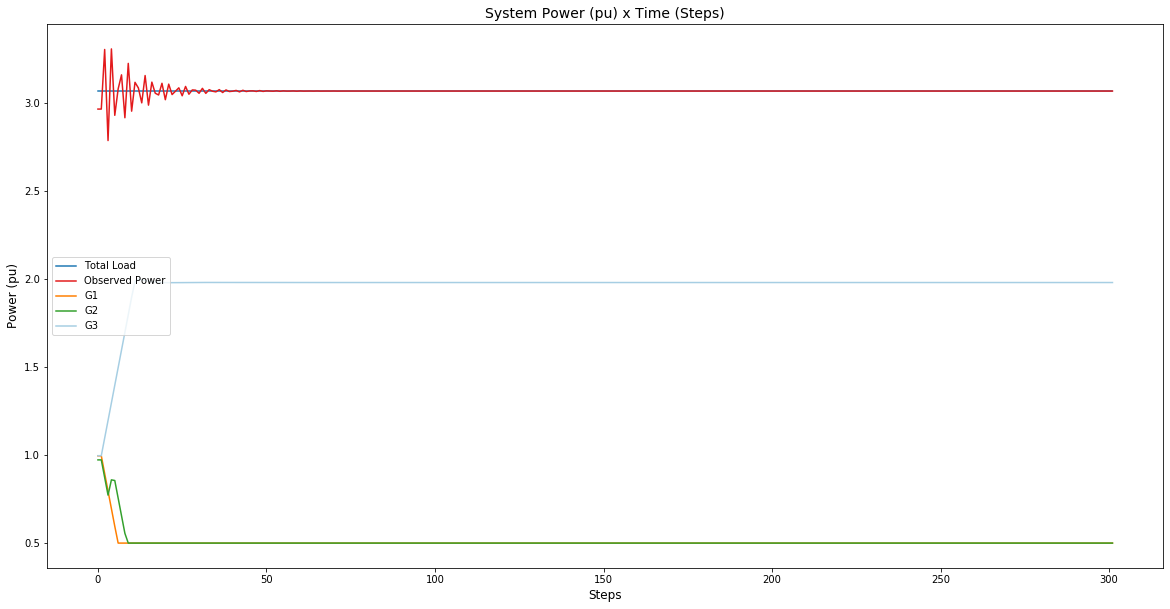

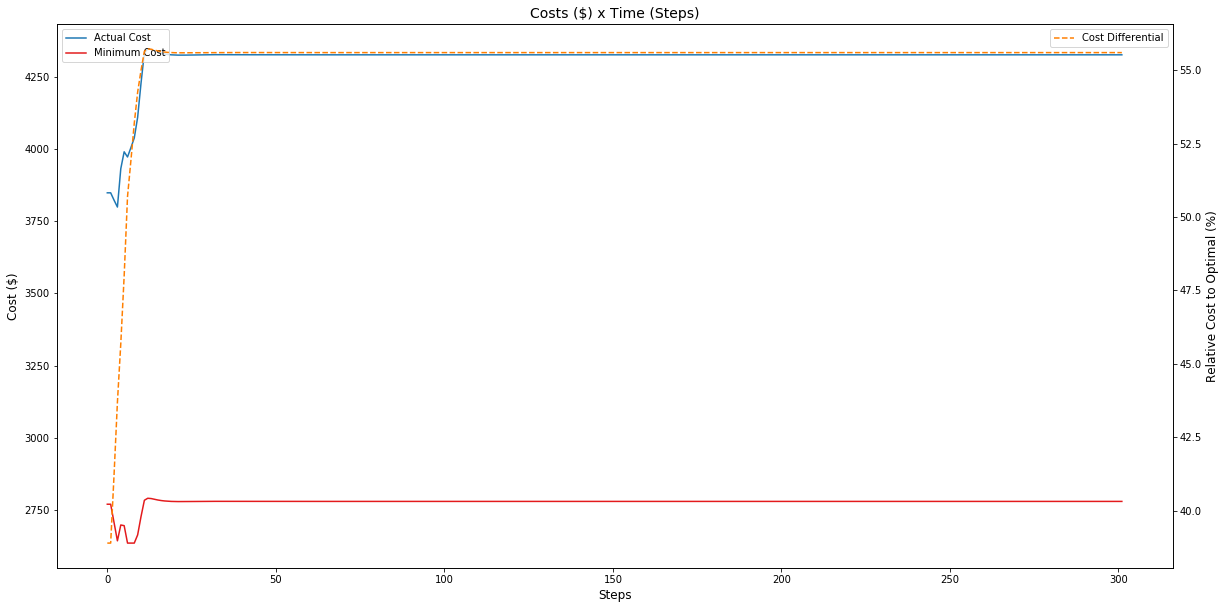

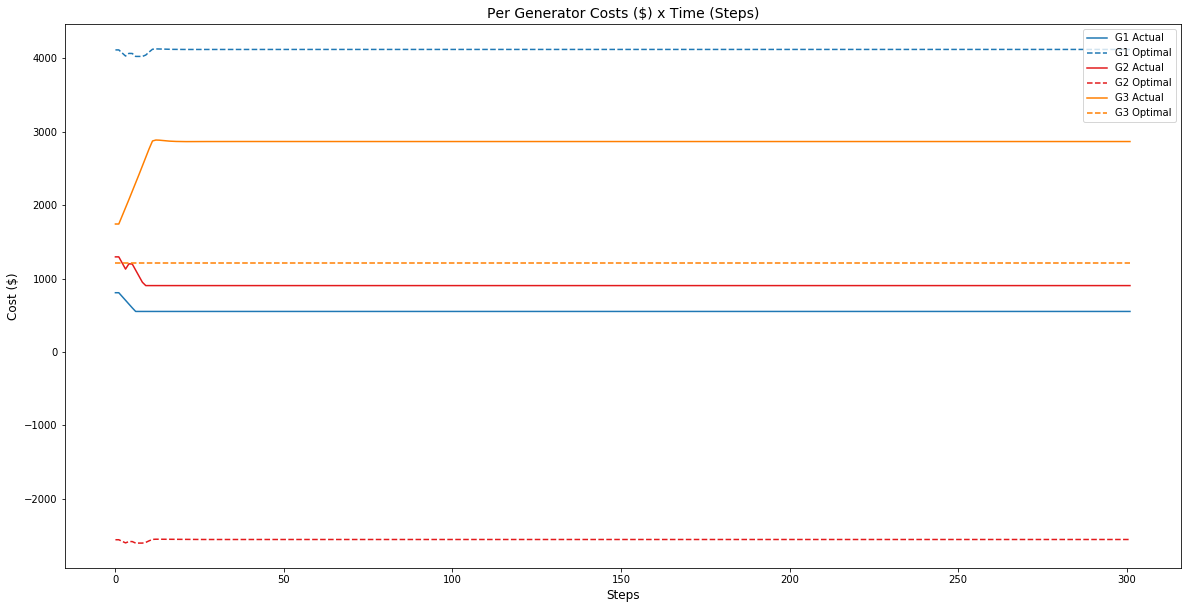

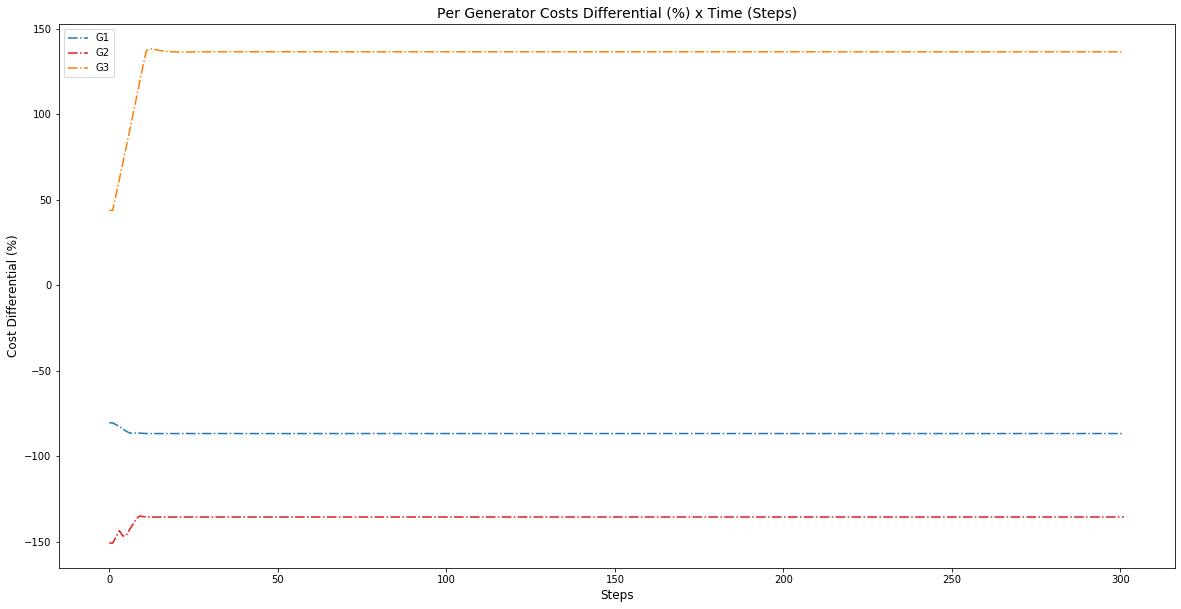

In [13]:
plotAll(electricalSystem.systemHistory)

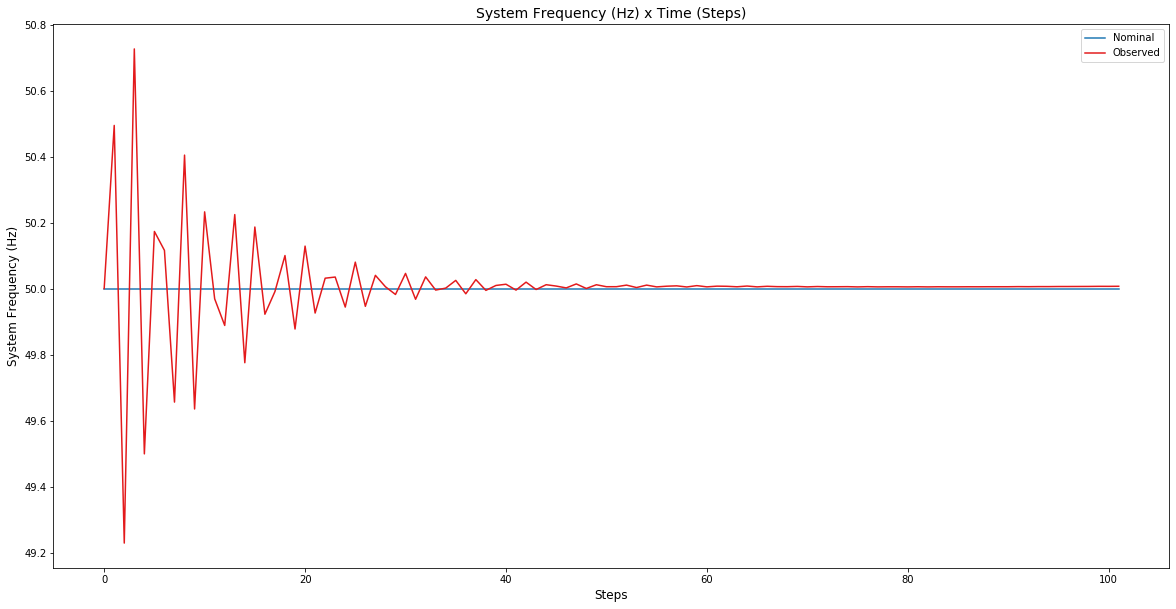

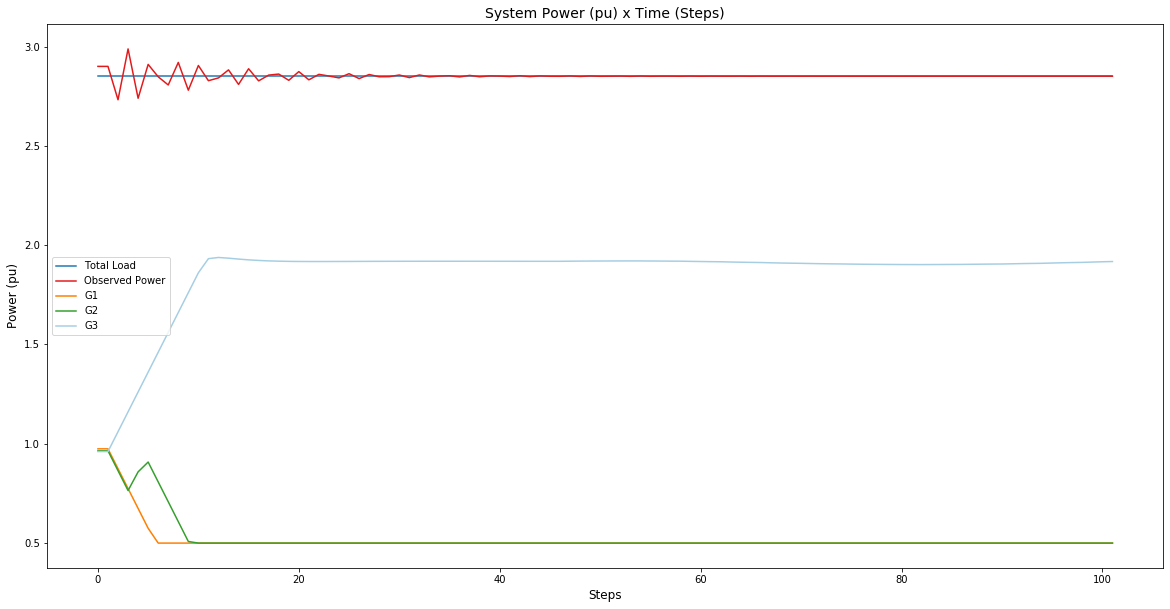

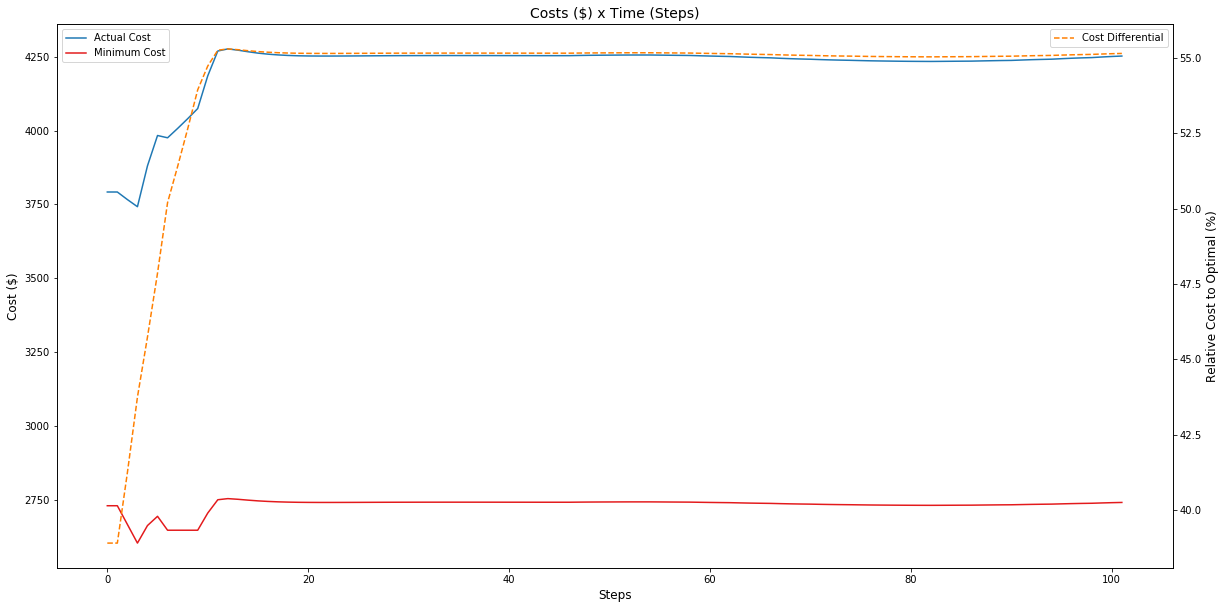

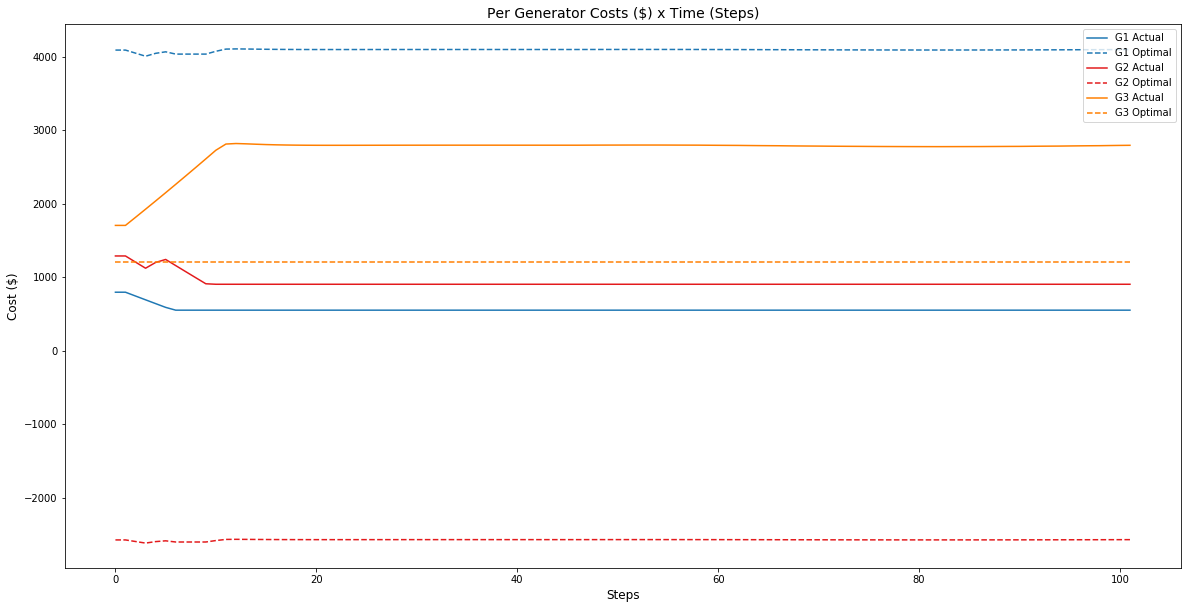

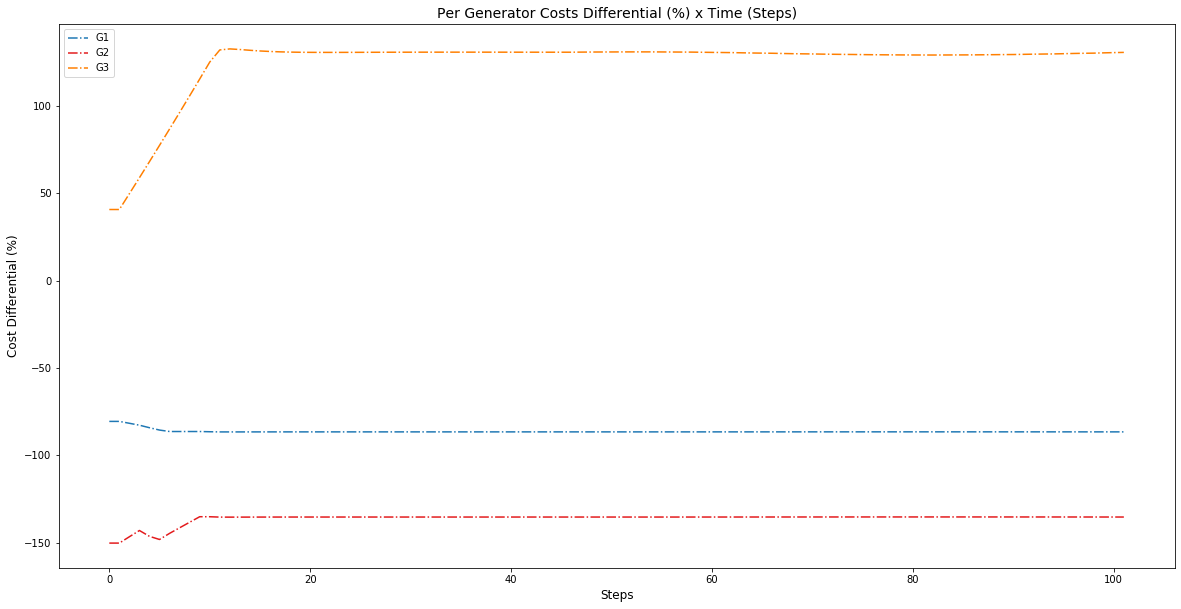

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.6315938302071628,
   'output': 6.46223185089538e-43,
   'total': 4.081505766393735e-43},
  {'cost': 0.6574724607915606,
   'output': 2.0646307434089638e-27,
   'total': 1.3574378554950006e-27},
  {'cost': 0.6798746760504033,
   'output': 2.1586042191240437e-20,
   'total': 1.467580344197993e-20},
  {'cost': 0.7232519487396878,
   'output': 1.388407926010395e-10,
   'total': 1.0041687381326464e-10},
  {'cost': 0.6964690643512876,
   'output': 1.8318397560026374e-21,
   'total': 1.2758197209046478e-21},
  {'cost': 0.6181162837144496,
   'output': 7.589921229943105e-53,
   'total': 4.691453904337837e-53},
  {'cost': 0.6276835353766695,
   'output': 2.467906617561054e-49,
   'total': 1.5490643506902006e-49},
  {'cost': 0.5618779585778056,
   'output': 1.9319105609302762e-91,
   'total': 1.085497962130407e-91},
  {'cost': 0.6715200496525277,
   'output': 4.074885286522558e-31,
   'total': 2.7363671699339825e-31},
  {'cost': 0.6802879497016588,
   'output': 3.282748426487513e-23

TypeError: float() argument must be a string or a number, not 'dict'

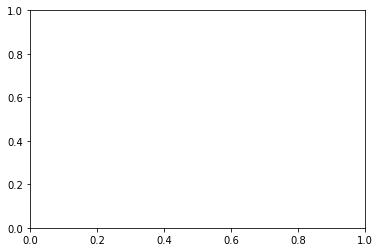

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()